/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_11202/139527713.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,diff(),diff().shift(1),Target,RSI
8172,625.844910,627.729638,624.728011,627.560125,65621600,-0.458679,1.186707,-624.658203,65.800710
8173,627.031616,629.793916,626.602812,627.031616,63375000,1.186707,0.089722,-626.941895,67.073294
8174,627.121338,627.988928,624.458737,627.360665,60046300,0.089722,5.335266,-621.786072,67.587073
8175,632.456604,632.456604,627.988949,629.803924,70511000,5.335266,0.209351,-632.247253,69.988460
8176,632.665955,634.391213,632.237151,632.845450,71307100,0.209351,2.672607,-629.993347,65.265656
...,...,...,...,...,...,...,...,...,...
8253,683.000000,683.570007,678.729980,679.950012,58953400,1.559998,0.380005,-682.619995,62.446759
8254,683.380005,684.960022,680.950012,684.789978,62312500,0.380005,-11.340027,-694.720032,60.107841
8255,672.039978,680.859985,670.520020,680.500000,103457800,-11.340027,-0.109985,-672.149963,45.886617
8256,671.929993,675.659973,663.270020,665.380005,96846700,-0.109985,-6.260010,-678.190002,37.998228


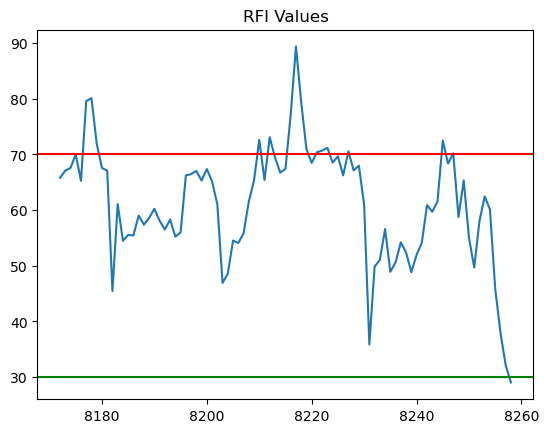

In [ ]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn as sk

# Step 1: Ticker
TICKER = "SPY"

# Step 2: Price Behavior 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"

# Step 3: RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

# Step 3: Price difference
SHIFT = 1
    # Tomorrow's Close Price in the same Row as today

# Step 5: Data Subsection
LOOKBACK = 100

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 0 of Multilevel Columns
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots
    df = df.reset_index(drop=True)

    return df.iloc[-lookback:, :]
        # -lookback: all loockback rows
        # : all columns 

# Defining y/the Dependent/the Target Variable
# --> We can create a strategy, that could forecast positively/negatively 
# with our Close Price changes 

# Lets inspect how a tech Indicator is related to how a price changes tomorrow
# For eg. RSI - you want to see a negative correlation between value of the RSI
# and Close Price Change the following day. Because the higher the value of RSI, 
# the more overbought the asset and shoudl decrease soon 
def add_target(df, shift = SHIFT):

    # Step 1:
    df["diff()"] = df["Close"].diff()

    # Step 2: 
    df[f"diff().shift({shift})"] = df["Close"].diff().shift(-shift)
    # diff(): Today's Price - Yesterday's Price == how much money you made or lost today
    # shift(-1): shift backwards in time. It takes the diff value from tomorrow into the row for today
    # We are trying to find a correlation with the price of tomorrow

    # Step 3: Finding Momentum. What is the difference between Close Price today and five days from now?
    df["Target"] = df[f"diff().shift({shift})"] - df["Close"]

    return df

# Adding the Features: we want to create a Corelation between the Target and RSI 

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    
    # Step 1: Define Delta (Price changes between the Rows)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Negative Returns
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # Step 3: Calculate the Rolling Average for Length Days
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    # Step 4: Calculate the Relative Strength
    rs = avg_gain / avg_loss
        # In percentage Terms: how much stronger have the Up Days been compared to the Down Days
        # rs = 3: avg_gain was 3x larger than the average loss --> Strong Upward Momentum
        # rs = 0.5: avg_gain was half the size of the average loss --> Strong Downward Momentum

    # Step 5: Calculate the RSI w/ Standardization (Values between 0-100)
    df["RSI"] = 100 - (100/(1+rs))

    # Step 6: Plot the RSI
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Step 7: Plot horizontal lines for Overbrought/Oversold
    plt.axhline(overbrought, color="red")
    plt.axhline(oversold, color="green")
        # Crossing Overbrought Line: triggers Short Signal 
        # Crossing Oversold Line: triggers Long Signal
    
    return df.dropna()

# Using our Scikit Library, to understand how our RSI is related to future price movements


def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)

    return df

df = main()
df

In [28]:
df.tail(10)

Price,Close,High,Low,Open,Volume,diff(),diff().shift(1),Target,RSI
8248,675.239990,679.960022,674.580017,676.109985,78427000,-8.100037,2.340027,-672.899963,58.764147
8249,677.580017,680.859985,674.169983,674.979980,74402400,2.340027,-7.270020,-684.850037,65.327525
8250,670.309998,677.380005,668.719971,676.469971,85035300,-7.270020,0.659973,-669.650024,55.035704
8251,670.969971,671.080017,661.210022,667.909973,100592400,0.659973,10.470032,-660.499939,49.685878
8252,681.440002,682.179993,675.030029,677.239990,75842900,10.470032,1.559998,-679.880005,58.056839
8253,683.000000,683.570007,678.729980,679.950012,58953400,1.559998,0.380005,-682.619995,62.446759
8254,683.380005,684.960022,680.950012,684.789978,62312500,0.380005,-11.340027,-694.720032,60.107841
8255,672.039978,680.859985,670.520020,680.500000,103457800,-11.340027,-0.109985,-672.149963,45.886617
8256,671.929993,675.659973,663.270020,665.380005,96846700,-0.109985,-6.260010,-678.190002,37.998228
8257,665.669983,673.710022,662.169983,669.700012,90456100,-6.260010,-5.589966,-671.259949,32.142289
